In [2]:
from monai.transforms import (
    AddChanneld,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
)
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")
data_dir = os.path.join(root_dir,"unetr")
print(f"data dir is:{data_dir}")

root dir is: /home/xindong/project/data
data dir is:/home/xindong/project/data/unetr


In [4]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]

In [5]:
train_data_dicts[0]
for data in train_data_dicts:
    print(data)

{'image': '/home/xindong/project/data/unetr/imagesTr/img0001.nii.gz', 'label': '/home/xindong/project/data/unetr/labelsTr/label0001.nii.gz'}
{'image': '/home/xindong/project/data/unetr/imagesTr/img0002.nii.gz', 'label': '/home/xindong/project/data/unetr/labelsTr/label0002.nii.gz'}
{'image': '/home/xindong/project/data/unetr/imagesTr/img0003.nii.gz', 'label': '/home/xindong/project/data/unetr/labelsTr/label0003.nii.gz'}
{'image': '/home/xindong/project/data/unetr/imagesTr/img0004.nii.gz', 'label': '/home/xindong/project/data/unetr/labelsTr/label0004.nii.gz'}
{'image': '/home/xindong/project/data/unetr/imagesTr/img0005.nii.gz', 'label': '/home/xindong/project/data/unetr/labelsTr/label0005.nii.gz'}
{'image': '/home/xindong/project/data/unetr/imagesTr/img0006.nii.gz', 'label': '/home/xindong/project/data/unetr/labelsTr/label0006.nii.gz'}
{'image': '/home/xindong/project/data/unetr/imagesTr/img0007.nii.gz', 'label': '/home/xindong/project/data/unetr/labelsTr/label0007.nii.gz'}
{'image': '/h

In [6]:
loader = LoadImage(dtype=np.float32)

In [7]:
image,metadata = loader(train_data_dicts[0]["image"])
print(f"input: {train_data_dicts[0]['image']}")
print(f"image shape: {image.shape}")
print(f"image affine:\n{metadata['affine']}")
print(f"image pixdim:\n{metadata['pixdim']}")

input: /home/xindong/project/data/unetr/imagesTr/img0001.nii.gz
image shape: (512, 512, 147)
image affine:
[[  -0.66796875    0.            0.          170.66601562]
 [   0.            0.66796875    0.         -170.66601562]
 [   0.            0.            3.         -219.        ]
 [   0.            0.            0.            1.        ]]
image pixdim:
[1.         0.66796875 0.66796875 3.         0.         0.
 0.         0.        ]


In [8]:
loader = LoadImaged(keys=("image", "label"))

In [9]:
data_dict = loader(train_data_dicts[0])
print(f"input:, {train_data_dicts[0]}")
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image pixdim:\n{data_dict['image_meta_dict']['pixdim']}")

input:, {'image': '/home/xindong/project/data/unetr/imagesTr/img0001.nii.gz', 'label': '/home/xindong/project/data/unetr/labelsTr/label0001.nii.gz'}
image shape: (512, 512, 147)
label shape: (512, 512, 147)
image pixdim:
[1.         0.66796875 0.66796875 3.         0.         0.
 0.         0.        ]


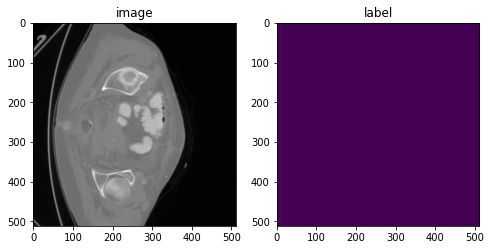

In [10]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()

In [11]:
add_channel = AddChanneld(keys=["image", "label"])
datac_dict = add_channel(data_dict)
print(f"image shape: {datac_dict['image'].shape}")

image shape: (1, 512, 512, 147)


In [12]:
spacing = Spacingd(keys=["image", "label"], pixdim=(
    1.5, 1.5, 5.0), mode=("bilinear", "nearest"))

In [13]:
data_dict = spacing(datac_dict)
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after Spacing:\n{data_dict['image_meta_dict']['affine']}")
print(f"label affine after Spacing:\n{data_dict['label_meta_dict']['affine']}")

image shape: (1, 229, 229, 89)
label shape: (1, 229, 229, 89)
image affine after Spacing:
[[  -1.5           0.            0.          170.66601562]
 [   0.            1.5           0.         -170.66601562]
 [   0.            0.            5.         -219.        ]
 [   0.            0.            0.            1.        ]]
label affine after Spacing:
[[  -1.5           0.            0.          170.66601562]
 [   0.            1.5           0.         -170.66601562]
 [   0.            0.            5.         -219.        ]
 [   0.            0.            0.            1.        ]]


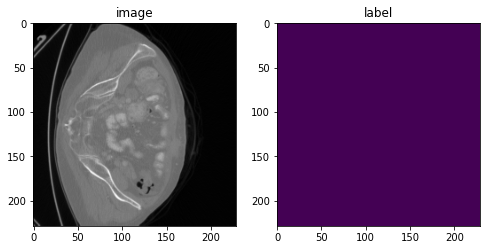

In [14]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 30])
plt.show()

In [15]:
orientation = Orientationd(keys=["image", "label"], axcodes="PLI")

In [16]:
data_dict = orientation(data_dict)
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print(f"image affine after Spacing:\n{data_dict['image_meta_dict']['affine']}")
print(f"label affine after Spacing:\n{data_dict['label_meta_dict']['affine']}")

image shape: (1, 229, 229, 89)
label shape: (1, 229, 229, 89)
image affine after Spacing:
[[  0.          -1.5          0.         170.66601562]
 [ -1.5          0.           0.         171.33398438]
 [  0.           0.          -5.         221.        ]
 [  0.           0.           0.           1.        ]]
label affine after Spacing:
[[  0.          -1.5          0.         170.66601562]
 [ -1.5          0.           0.         171.33398438]
 [  0.           0.          -5.         221.        ]
 [  0.           0.           0.           1.        ]]


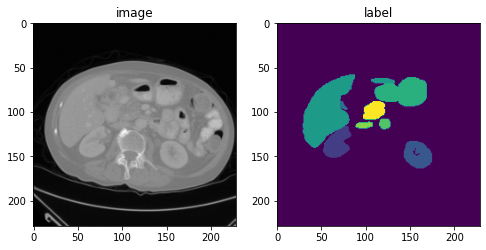

In [17]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 30])
plt.show()

## 仿射变换

In [29]:
rand_affine = RandAffined(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,# 返回随机网格的概率，默认是0.1 10%
    spatial_size=(300, 300, 50),# 设置尺寸
    translate_range=(40, 40, 2),
    #rotate_range=(np.pi / 36, np.pi / 36, np.pi / 36),#以弧度为单位的角度范围(-np.pi / 36,np.pi / 36),(-np.pi / 36,np.pi / 36),(-np.pi / 36,np.pi / 36)
    rotate_range=((-np.pi / 36,np.pi / 36),(-np.pi / 36,np.pi / 36),(-np.pi / 36,np.pi / 36)),
    scale_range=(0.15, 0.15, 0.15),#缩放默认是1，0则不做任何变化
    padding_mode="border",#pading 模式
)

image shape: torch.Size([1, 300, 300, 50])


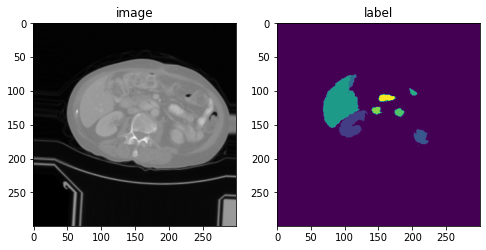

In [30]:
affined_data_dict = rand_affine(data_dict)
print(f"image shape: {affined_data_dict['image'].shape}")

image, label = affined_data_dict["image"][0], affined_data_dict["label"][0]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 15], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 15])
plt.show()

## 随机弹性变形

In [31]:
rand_elastic = Rand3DElasticd(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    sigma_range=(5, 8),#平滑高斯内核
    magnitude_range=(100, 200),#网格随机偏移量
    spatial_size=(300, 300, 10),#尺寸
    translate_range=(50, 50, 2),#平移
    rotate_range=(np.pi / 36, np.pi / 36, np.pi),#旋转
    scale_range=(0.15, 0.15, 0.15),#缩放
    padding_mode="border",
)

image shape: (1, 300, 300, 10)


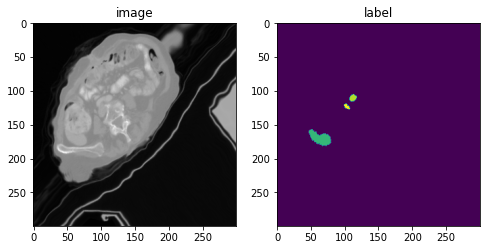

In [32]:
deformed_data_dict = rand_elastic(data_dict)
print(f"image shape: {deformed_data_dict['image'].shape}")

image, label = deformed_data_dict["image"][0], deformed_data_dict["label"][0]
plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 5], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 5])
plt.show()